## Finding the lowest eigenvalue of a matrix

### Task 4 - Quantum Open Source Foundation

In [98]:
from qiskit import*
from qiskit.visualization import*
from math import*
import matplotlib.pyplot as plt
import numpy as np

In [99]:
H = np.matrix([[1,0,0,0],[0,0,-1,0],[0,-1,0,0],[0,0,0,1]])
print(H)

[[ 1  0  0  0]
 [ 0  0 -1  0]
 [ 0 -1  0  0]
 [ 0  0  0  1]]


#### In order to write the matrix $H$ above as a sum of Pauli terms $(XX, YY, ZZ, II)$, we can use the following expression
#### $$H = \sum h_{i,j}\left(\sigma_i\otimes\sigma_j\right)$$
#### where $$h_{i,j}=\frac{1}{4}Tr[\left(\sigma_i\otimes\sigma_j\right). H]$$

In [100]:
xx = np.matrix([[0,0,0,1],[0,0,1,0],[0,1,0,0],[1,0,0,0]])
yy = np.matrix([[0,0,0,-1],[0,0,1,0],[0,1,0,0],[-1,0,0,0]])
zz = np.matrix([[1,0,0,0],[0,-1,0,0],[0,0,-1,-0],[0,0,0,1]])
ii = np.matrix([[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]])

coef_xx = 0.25*np.trace(np.matmul(xx,H))
coef_yy = 0.25*np.trace(np.matmul(yy,H))
coef_zz = 0.25*np.trace(np.matmul(zz,H))
coef_ii = 0.25*np.trace(np.matmul(ii,H))

print('H =')
print('%.1f*XX' %(coef_xx))
print('%.1f*YY' %(coef_yy))
print('%.1f*ZZ' %(coef_zz))
print('%.1f*II' %(coef_ii))

H =
-0.5*XX
-0.5*YY
0.5*ZZ
0.5*II


## Variational Quantum Eigensolver (VQE)

##### According https://qiskit.org/textbook/ch-applications/vqe-molecules.html the VQE can be stated by 

##### $$\lambda_{min}≤\lambda_{\theta}≡ \langle\psi\left(\theta\right)|H|\psi\left(\theta\right)\rangle$$

##### $|\psi\left(\theta\right)\rangle$ is a parametrized circuit called ansatz. In order to estimate the lowest eigenvalue of operator *H*, the circuit is iteratively optimized by a classical controller changing the parameter  $θ$  minimizing the expectation value $\langle\psi\left(\theta\right)|H|\psi\left(\theta\right)\rangle$.

##### In this task the given $H$ is represented as a sum of pauli terms as follow

##### $$H=\frac{1}{2}ZZ+\frac{1}{2}II-\frac{1}{2}XX-\frac{1}{2}YY$$

##### for each iteration we have the expected value of H as the sum of the expected values of each Pauli operator

##### $$\langle\psi\left(\theta\right)|H|\psi\left(\theta\right)\rangle = \frac{1}{2}\langle\psi\left(\theta\right)|ZZ|\psi\left(\theta\right)\rangle + \frac{1}{2}\langle\psi\left(\theta\right)|II|\psi\left(\theta\right)\rangle - \frac{1}{2}\langle\psi\left(\theta\right)|XX|\psi\left(\theta\right)\rangle -\frac{1}{2}\langle\psi\left(\theta\right)|YY|\psi\left(\theta\right)\rangle$$


##### Next, we create an ansatz

In [101]:
def var_circuit (variational_parameter):
    circ = QuantumCircuit(2)
    circ.h(0)
    circ.cx(0,1)
    circ.rx(variational_parameter,0)    
    
    return circ
    


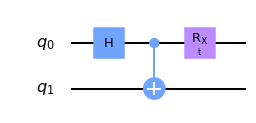

In [114]:
var_circuit(variational_parameter='t').draw('mpl')

In [103]:
'''Define a measurement at computational Z basis:'''

def measureZZ (given_circuit):
    zz_meas = given_circuit.copy()
    zz_meas.measure_all()
    return zz_meas


In [104]:
def measure_ZZ(given_circuit,num_shots=10000):
    
    zz_meas = measureZZ(given_circuit)
    
    result = execute(zz_meas,Aer.get_backend('qasm_simulator'),shots = num_shots).result()
    counts = result.get_counts(zz_meas)
    
    if '00' not in counts:
        counts['00'] = 0
    if '01' not in counts:
        counts['01'] = 0
    if '10' not in counts:
        counts['10'] = 0
    if '11' not in counts:
        counts['11'] = 0
        
    '''
    Remembering that:
    
    ZZ|00> = |00>
    ZZ|01> = -|01>
    ZZ|10> = -|10>
    ZZ|11> = |11>
    
    '''
    
    total_counts = counts['00'] + counts['10'] + counts['01'] + counts['11']
    ZZ = counts['00'] + counts['11'] - counts['01']  - counts['10'] 
    
    zz = ZZ/total_counts
    
    return zz

In [105]:
def measureXX(given_circuit):
    xx_meas = given_circuit.copy()
    
    '''
    Change from Z basis to X basis by applying Hadamard gate to each qubit    
    '''
    xx_meas.h(0)
    xx_meas.h(1)
    xx_meas.measure_all()
    return xx_meas

In [106]:
def measure_XX(given_circuit, num_shots = 10000):
    
    xx_meas = measureXX(given_circuit)
    
    result = execute(xx_meas,Aer.get_backend('qasm_simulator'),shots=num_shots).result()
    counts = result.get_counts(xx_meas)
    
    if '00' not in counts:
        counts['00'] = 0
    if '01' not in counts:
        counts['01'] = 0
    if '10' not in counts:
        counts['10'] = 0
    if '11' not in counts:
        counts['11'] = 0 
        
    total_counts = counts['00'] + counts['10'] +counts['01'] +counts['11']
    
    '''
    XX -> ZZ
    
    '''
    XX = counts['00'] + counts['11'] -counts['01'] -counts['10']
    
    XX = XX/total_counts
    
    return XX


In [107]:
def measureYY(given_circuit):
    yy_meas = given_circuit.copy()
    
    '''
    Change each qubit from Z basis to Y basis by applying Sdagger gate followed by Hadamard gate
    
    '''
    yy_meas.h(0)
    yy_meas.h(1)
    yy_meas.sdg(0)
    yy_meas.sdg(1)
    
    
    yy_meas.measure_all()
    
    return yy_meas

In [108]:
def measure_YY(given_circuit,num_shots = 10000):
    
    yy_meas = measureYY(given_circuit)
    
    result = execute(yy_meas,Aer.get_backend('qasm_simulator'),shots=num_shots).result()
    counts = result.get_counts(yy_meas)
    
    if '00' not in counts:
        counts['00'] = 0
    if '01' not in counts:
        counts['01'] = 0
    if '10' not in counts:
        counts['10'] = 0
    if '11' not in counts:
        counts['11'] = 0
        
    '''
    YY -> ZZ
    '''
    total_counts = counts['00']  + counts['10']  + counts['01']  + counts['11']   
    YY =  counts ['00'] + counts['11'] - counts['10'] - counts['01'] 
    YY = YY/total_counts
    
    return YY

In [109]:


def eigenvalues(given_circuit,num_shots = 10000):
    
    xx = measure_XX(given_circuit,num_shots=num_shots)
    yy = measure_YY(given_circuit,num_shots=num_shots)
    zz = measure_ZZ(given_circuit,num_shots=num_shots)
    ii = 1
    
    energy = 0.5*zz + 0.5*ii - 0.5*yy - 0.5*xx
    
    return energy

In [110]:
H = []

angle = np.linspace(0,2*np.pi,128)

for i in range(0,len(angle)):

    ansatz = var_circuit(variational_parameter= angle[i])
    energy = eigenvalues(ansatz)
    H.append(energy)
    print('Angle: %f  <H>: %f' %(angle[i],energy))

Angle: 0.000000  <H>: 0.000000
Angle: 0.049474  <H>: -0.000600
Angle: 0.098948  <H>: -0.002400
Angle: 0.148422  <H>: -0.005100
Angle: 0.197896  <H>: -0.009500
Angle: 0.247370  <H>: -0.015400
Angle: 0.296843  <H>: -0.021000
Angle: 0.346317  <H>: -0.027500
Angle: 0.395791  <H>: -0.039900
Angle: 0.445265  <H>: -0.048600
Angle: 0.494739  <H>: -0.057600
Angle: 0.544213  <H>: -0.073100
Angle: 0.593687  <H>: -0.084100
Angle: 0.643161  <H>: -0.101600
Angle: 0.692635  <H>: -0.113400
Angle: 0.742109  <H>: -0.127900
Angle: 0.791582  <H>: -0.153800
Angle: 0.841056  <H>: -0.167000
Angle: 0.890530  <H>: -0.188900
Angle: 0.940004  <H>: -0.205100
Angle: 0.989478  <H>: -0.223500
Angle: 1.038952  <H>: -0.249900
Angle: 1.088426  <H>: -0.268200
Angle: 1.137900  <H>: -0.292900
Angle: 1.187374  <H>: -0.307700
Angle: 1.236848  <H>: -0.334300
Angle: 1.286321  <H>: -0.368900
Angle: 1.335795  <H>: -0.380300
Angle: 1.385269  <H>: -0.402900
Angle: 1.434743  <H>: -0.426100
Angle: 1.484217  <H>: -0.456100
Angle: 1.

Opt angle = 3.166330 H_min = -1.000000


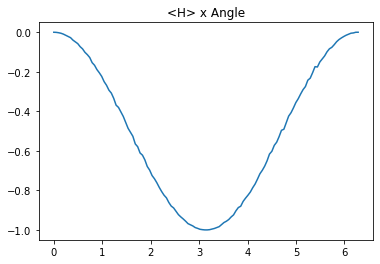

In [113]:
gc = plt.plot(angle,H)
plt.title('<H> x Angle')
a = H.index(min(H))
print('Opt angle = %f H_min = %f' %(angle[a],min(H)))